 #  <p style="text-align: center;">Technical Support Data Analysis

## Background:

AllLife Bank wants to focus on its credit card customer base in the next financial year. They have been advised by their marketing research team, that the penetration in the market can be improved. Based on this input, the Marketing team proposes to run personalised campaigns to target new customers as well as upsell to existing customers. Another insight from the market research was that the customers perceive the support services of the back poorly. Based on this, the Operations team wants to upgrade the service delivery model, to ensure that customers queries are resolved faster. Head of Marketing and Head of Delivery both decide to reach out to the Data Science team for help.

## Objective:
To identify different segments in the existing customer based on their spending patterns as well as past interaction with the bank.

## Key Questions:
1. How many different segments of customers are there?
2. How are these segments different from each other?
3. What are your recommendations to the bank on how to better market to and service these customers?

## Data Description:
Data is of various customers of a bank with their credit limit, the total number of credit cards the customer has, and different channels through which customer has contacted the bank for any queries, different channels include visiting the bank, online and through a call centre.


## Data Dictionary

- Sl_No: Primary key of the records
- Customer Key: Customer identification number
- Average Credit Limit: Average credit limit of each customer for all credit cards
- Total credit cards: Total number of credit cards possessed by the customer
- Total visits bank: Total number of visits that customer made (yearly) personally to the bank
- Total visits online: Total number of visits or online logins made by the customer (yearly)
- Total calls made: Total number of calls made by the customer to the bank or its customer service department (yearly)

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style; style.use('fivethirtyeight')
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering 
from sklearn.decomposition import PCA
from matplotlib import cm
from scipy.cluster.hierarchy import fcluster


roundoff = 4

random_state = 42
np.random.seed(random_state)

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

#Format:
pd.options.display.float_format = '{:.4f}'.format

In [290]:
df_ = pd.read_excel("Credit+Card+Customer+Data.xlsx")

In [291]:
df_.shape

(660, 7)

The dataset contains one record for each unique problem type. It has metrics for each type like count, average calls to resolve, average resolution time etc.

In [292]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


**Observation:**

- All columns are in int datatype
- No nulls being observed

In [9]:
df_.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


In [10]:
df_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


## Observation:

- 660 observations(rows) and 7 variables(features)
- Sl_No and Customer_Key can be dropped as it is not needed for model training
- There is no target variable here. So, we need to build an unsupervised learning model
- Credit limit has higher magnitude compared to other columns. We need to scale the features

In [11]:
df_.describe()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
count,660.0000,660.0000,660.0000,660.0000,660.0000,660.0000,660.0000
mean,330.5000,55141.4439,34574.2424,4.7061,2.4030,2.6061,3.5833
std,190.6699,25627.7722,37625.4878,2.1678,1.6318,2.9357,2.8653
min,1.0000,11265.0000,3000.0000,1.0000,0.0000,0.0000,0.0000
25%,165.7500,33825.2500,10000.0000,3.0000,1.0000,1.0000,1.0000
50%,330.5000,53874.5000,18000.0000,5.0000,2.0000,2.0000,3.0000
75%,495.2500,77202.5000,48000.0000,6.0000,4.0000,4.0000,5.0000
max,660.0000,99843.0000,200000.0000,10.0000,5.0000,15.0000,10.0000


**Observation:**

- "Avg_Credit_Limit" ranges from 3K to 200K with an avg of 34.5K but 50% of customers have less than 18K. So it is heavily right skewed. It has a Std Deviation of 34K
- "Total_Credit_Cards" ranges from 1 to 10 cards with an avg of ~5 and also 50% of customers have less than 5. It has a Std Deviation of ~5
- "Total_visits_bank" ranges from 0 to 5 times with an avg of ~2 and also 50% of customers have less than 2. It has a Std Deviation of ~2
- "Total_visits_online" ranges from 0 to 15 times with an avg of ~3 and also 50% of customers have less than 2. 75% of customers in the dataset have online visits less than 4. So it is heavily right skewed. It has a Std Deviation of ~3
- "Total_calls_made" ranges from 0 to 10 times with an avg of ~4 and also 50% of customers have less than 3. Little bit right skewed. It has a Std Deviation of ~3


**Checking for duplicates**


In [12]:
df_[df_.duplicated()].count()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

** No duplicates observed.

In [14]:
#Create a copy of the data
df = df_.copy()

In [15]:
df.drop(['Sl_No','Customer Key'], axis=1, inplace=True)

In [16]:
df.nunique()

Avg_Credit_Limit       110
Total_Credit_Cards      10
Total_visits_bank        6
Total_visits_online     16
Total_calls_made        11
dtype: int64

**Observation**

- there are 110 distinct avg credit limits
- There are 10 distinct total credit cards
- There are 6 distinct total visits bank
- There are 16 distinct total visits online
- There are 11 distinct total calls made

In [17]:
for i in df.columns:
    print(df[i].value_counts(normalize=True)*100)

8000     5.3030
6000     4.6970
9000     4.2424
13000    4.2424
19000    3.9394
          ...  
43000    0.1515
146000   0.1515
155000   0.1515
200000   0.1515
167000   0.1515
Name: Avg_Credit_Limit, Length: 110, dtype: float64
4    22.8788
6    17.7273
7    15.3030
5    11.2121
2     9.6970
1     8.9394
3     8.0303
10    2.8788
9     1.6667
8     1.6667
Name: Total_Credit_Cards, dtype: float64
2   23.9394
1   16.9697
0   15.1515
3   15.1515
5   14.8485
4   13.9394
Name: Total_visits_bank, dtype: float64
2    28.6364
0    21.8182
1    16.5152
4    10.4545
5     8.1818
3     6.6667
15    1.5152
7     1.0606
10    0.9091
12    0.9091
8     0.9091
11    0.7576
13    0.7576
9     0.6061
14    0.1515
6     0.1515
Name: Total_visits_online, dtype: float64
4    16.3636
0    14.6970
2    13.7879
1    13.6364
3    12.5758
6     5.9091
7     5.3030
9     4.8485
8     4.5455
5     4.3939
10    3.9394
Name: Total_calls_made, dtype: float64


**Observation** 


- 24% of customer visited bank twice and 15% of customers never visited bank. 85% visited atleast once
- ~22% of customer never did online banking. 78% of customers visited online banking atleast once
- ~15% of customers never called bank. 85% of customers called atleast once
- more number of customers below 10K avg credit limit
- 22% of customers have 4 credit cards and ~3% with 10 credit cards

## Univariate Analysis


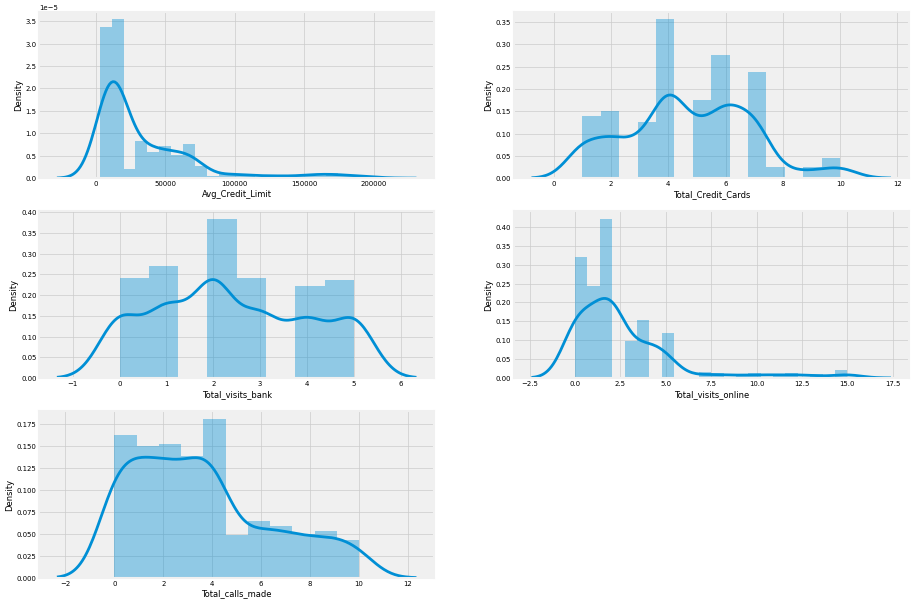

In [18]:
# univariate analysis for continuous variable
numcols = df.columns
fig, ax = plt.subplots(figsize=(20,15), dpi=50)
for i in range(0,len(numcols)):
    plt.subplot(3,2,i+1)
    sns.distplot(df[numcols[i]])
    plt.xlabel(numcols[i])

**Observation**

- Avg Credit limit is heavily right skewed
- more number of customers with lesser avg credit limits (<20K)
- credit cards, visits online, total calls have multiple peaks. majority of customers have 4 credit cards
- majority of customers visited bank twice. majority of customers visited bank online is twice
- majority of customers made <=4 calls to the bank

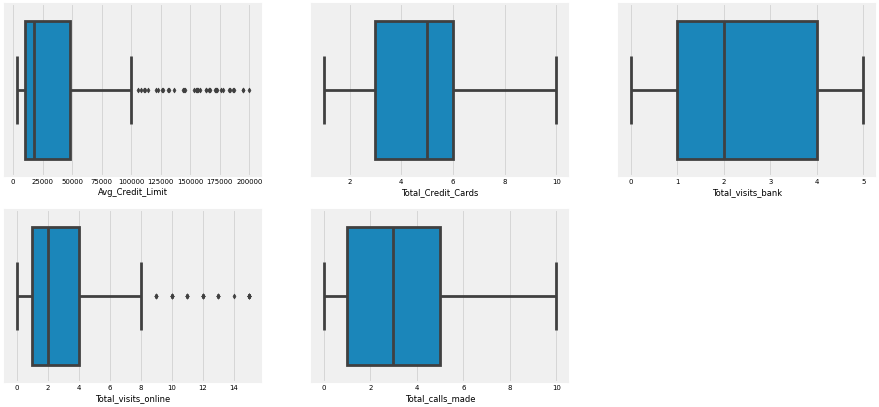

In [19]:
#Box plots
numcols = df.columns
fig, ax = plt.subplots(figsize=(20,10), dpi=50)
for i in range(0,len(numcols)):
    plt.subplot(2,3,i+1)
    sns.boxplot(df[numcols[i]])
    plt.xlabel(numcols[i])

**Observation**
- Avg Credit limit has lot of outliers
- visits online also has outliers

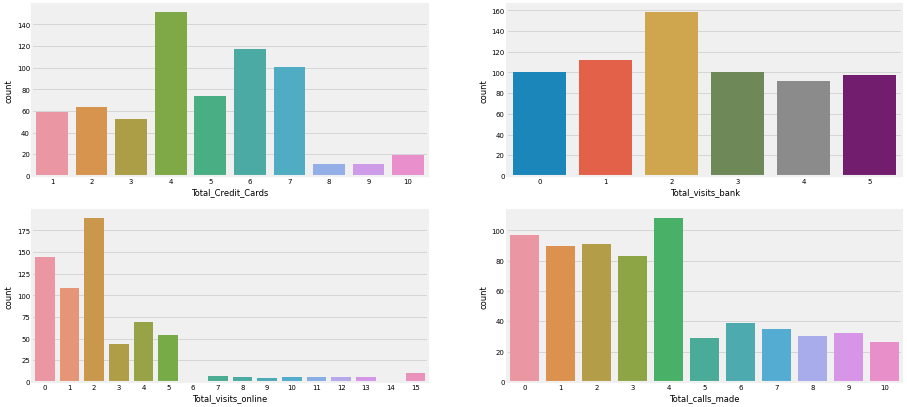

In [20]:
countscols = ['Total_Credit_Cards', 'Total_visits_bank',
       'Total_visits_online', 'Total_calls_made']
fig, ax = plt.subplots(figsize=(20,10), dpi=50)
for i in range(0,len(countscols)):
    plt.subplot(2,2,i+1)
    sns.countplot(df[countscols[i]])
    plt.xlabel(countscols[i])

**Observation:**

- Majority of customers have 4 credit cards and then 6 and 7 credit cards. Very few have >=8 cards
- ~160 customers visited bank twice
- majority of customers visited bank online is twice and majority of visits by most of the customers are <=5
- majority of customers made <=4 calls to the bank

### Bivariate Plots

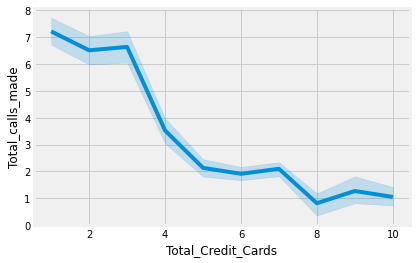

In [51]:
sns.lineplot(df['Total_Credit_Cards'],df['Total_calls_made']);


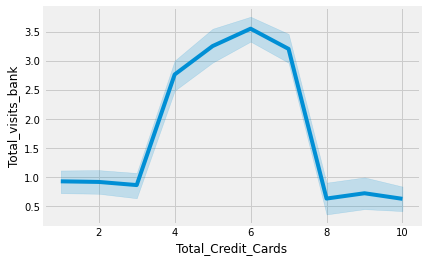

In [50]:
sns.lineplot(df['Total_Credit_Cards'],df['Total_visits_bank']);


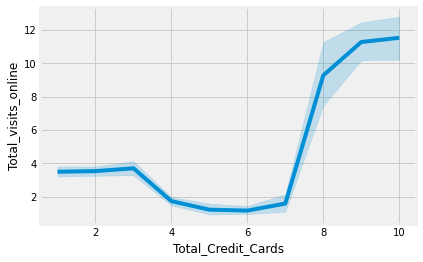

In [52]:
sns.lineplot(df['Total_Credit_Cards'],df['Total_visits_online']);

**Observation**
- One intresting observation is calls made to bank is reducing as the number of credit cards increased and customers who have less credit cards 1 - 3 are calling bank frequently.
- vists to bank is more for customers having credit cards between 4 to 7
- more visits online for customers having more credit cards 8 to 10

<AxesSubplot:xlabel='Total_Credit_Cards', ylabel='Avg_Credit_Limit'>

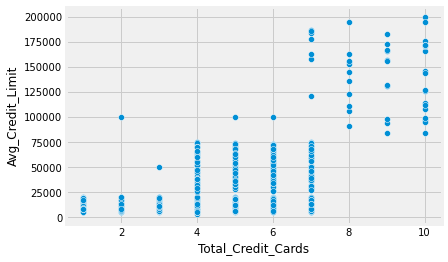

In [55]:
#Range of avg credit limit for each card Vs total credit cards
sns.scatterplot(df['Total_Credit_Cards'],df['Avg_Credit_Limit'])
#EG: For multiple customers having 1 credit card, credit limit ranges from 10K to 25K.... 
#for multiple customers having 10 credit card, credit limit ranges from 100K to 200K....

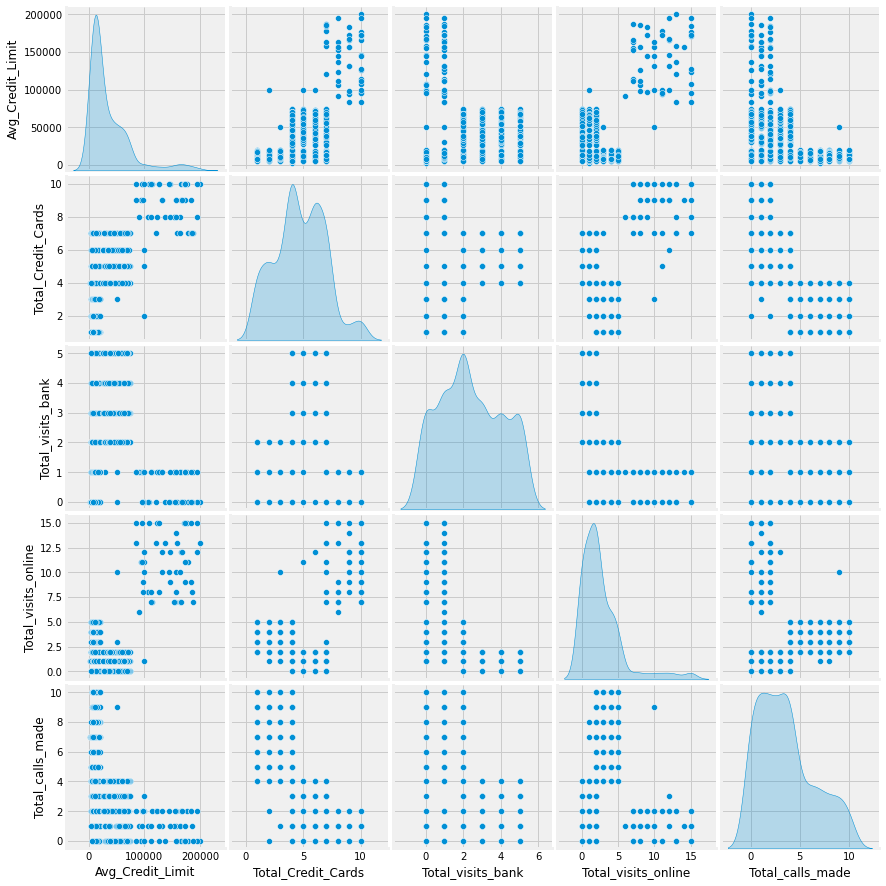

In [56]:
sns.pairplot(df, diag_kind='kde');

**Observation**

- Credit cards and visit online have positive relationship
- Credit limits and visit online have positive relationship
- Visit bank and visit online have negative relationship
- Visit to bank and calls made have negative relationship
- kind of -ve relationship between credit limit and calls made
- Credit limits and visit to bank; credit cards and calls made
- We can see 2 clusters between credit limit and credit cards
- 2 clusters between credit limit and visit online
- 2 clusters between total visits online and credit cards
- 3 clusters between total visits online and calls made

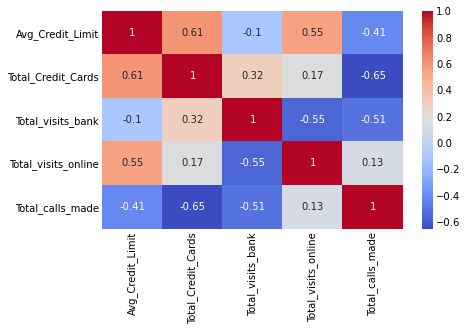

In [57]:
#Corr plot
plt.rcParams["figure.figsize"] = (6,4)
sns.heatmap(df.corr(),annot=True,cmap='coolwarm');
plt.show()

**Observations**


- Negative correlation (-0.65) between calls made and total credit cards
- Negative correlation (-0.55) between online visits and bank visits
- Negative correlation (-0.51) between calls made and vists to bank
- Positive correlation (0.61) between credit limit and no. of cards
- Positive correlation (0.55) between credit limit and visits online
- Negative correlation (-0.41) between credit limit and calls made

### Feature Generation


In [21]:
df_beforefeatureextraction = df.copy()
df['TotalCreditLimit'] = df['Avg_Credit_Limit']*df['Total_Credit_Cards']
df.drop(['Total_Credit_Cards','Avg_Credit_Limit'],axis=1,inplace=True)

In [59]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit
0,1,1,0,200000
1,0,10,9,150000
2,1,3,4,350000
3,1,1,4,150000
4,0,12,3,600000


### Normalize / Scale data using MinMax Scaler
- Normalization is good to use when you know that the distribution of your data does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors, Neural Networks or Distance based algorithms

In [22]:
# from scipy.stats import zscore

df_beforescaling = df.copy()
# df =df.apply(zscore)


from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df.loc[:,:] = scaler.fit_transform(df)

In [23]:
df_final = df.copy()

In [24]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit
0,0.2000,0.0667,0.0000,0.0977
1,0.0000,0.6667,0.9000,0.0727
2,0.2000,0.2000,0.4000,0.1729
3,0.2000,0.0667,0.4000,0.0727
4,0.0000,0.8000,0.3000,0.2982


### Feature Engineering


In [26]:
from sklearn.cluster import KMeans

cluster_range = range(1,10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 20,max_iter=300,random_state=random_state,init="k-means++",)
    clusters.fit_predict(df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df.sort_values('cluster_errors', ascending=True,inplace=True)
clusters_df[0:15]


,num_clusters,cluster_errors
8,9,18.0618
7,8,19.4582
6,7,22.0778
5,6,25.1243
4,5,28.3708
3,4,34.2345
2,3,50.4227
1,2,88.7884
0,1,167.5649


Text(0, 0.5, 'Inertia or WCSS')

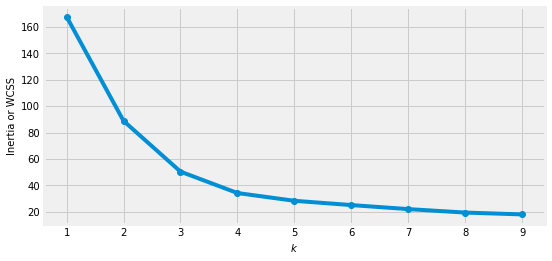

In [27]:
from matplotlib import cm

plt.figure(figsize=(8,4))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );
plt.xlabel("$k$", fontsize=10)
plt.ylabel("Inertia or WCSS", fontsize=10)

**Observation**

- From the above graph of "Elbow Method", we can find the possible number of clusters. From the graph, we can see the elbow bend at 3.
- we can choose K=3 or K=4
- At k=3 we have an inertia of 50.42 and at K=4 we have 34.23
- Will decide K based on Silhouette score

##### Selecting the number of clusters k using the silhouette score


In [29]:
silhouette_score_list = []
kmeans_kwargs = {
    "init": "k-means++",
   "n_init": 20,
   "max_iter": 300,
   "random_state": random_state,}

for k in range(2, 15):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit_predict(df)
   score = silhouette_score(df, kmeans.labels_)
   silhouette_score_list.append(score)

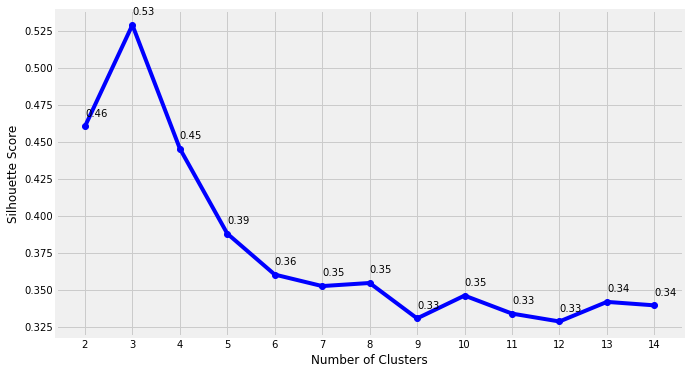

In [30]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 15), silhouette_score_list,'bo-')
plt.xticks(range(2, 15))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
# zip joins x and y coordinates in pairs
for x,y in zip(range(2, 15), silhouette_score_list):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center

plt.show()

**Observation**

- This visualization is much richer than the previous one: although it confirms that k = 3 is a very good choice, it also underlines the fact that k = 4 is not that good, and much better than k = 6,7, 8,9... This was not visible when comparing inertias.
- At K=3, we have a Sil.Score of 0.53.
- We will take K=3

In [50]:
kmeans_per_k = [KMeans(n_clusters=k, random_state=random_state,n_init=20,max_iter=300).fit(df)
                for k in range(1, 10)]
silhouette_scores = [silhouette_score(df, model.labels_)
                     for model in kmeans_per_k[1:]]

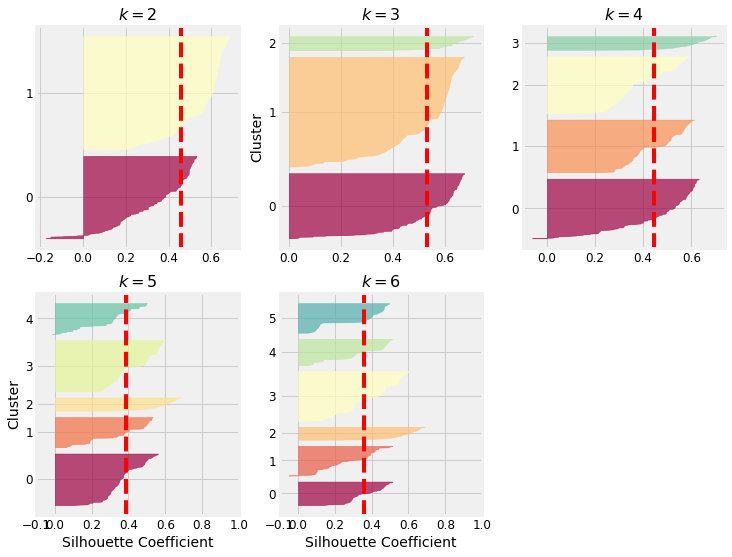

In [33]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


plt.figure(figsize=(11, 9))

for k in (2, 3, 4, 5, 6):
    plt.subplot(2, 3, k - 1)
    
    y_pred = kmeans_per_k[k - 1].labels_
    silhouette_coefficients = silhouette_samples(df, y_pred)

    padding = len(df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]
        coeffs.sort()

        color = mpl.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
    if k in (3, 5):
        plt.ylabel("Cluster")
    
    if k in (5, 6):
        plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
        plt.xlabel("Silhouette Coefficient")
    else:
        plt.tick_params(labelbottom=True)

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title("$k={}$".format(k), fontsize=16)

# save_fig("silhouette_analysis_plot")
plt.show()

**Observation**
- when k = 3, the clusters look good: most instances extend beyond the dashed line, to the right and closer to 1.0

In [288]:
df = df_final.copy()

In [289]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit
0,0.2000,0.0667,0.0000,0.0977
1,0.0000,0.6667,0.9000,0.0727
2,0.2000,0.2000,0.4000,0.1729
3,0.2000,0.0667,0.4000,0.0727
4,0.0000,0.8000,0.3000,0.2982


#### Running KMeans with 3 clusters based on high Silhouette score and optimal low inertia based on Elbow method

In [388]:
kmeans = KMeans(n_clusters=3,n_init = 500,max_iter=1000,random_state=random_state,init="k-means++")

In [384]:
kmeans.fit(df)
ypred = kmeans.labels_

In [359]:
#3 Cluster centroids that the algorithm found
kmeans.cluster_centers_

array([[ 1.88596491e-01,  2.35087719e-01,  6.82017544e-01,
         1.35953920e-02,  1.00000000e+00,  3.00000000e+00],
       [ 7.02094241e-01,  6.47469459e-02,  1.97905759e-01,
         9.10666719e-02, -1.44328993e-15,  2.00000000e+00],
       [ 1.20000000e-01,  7.26666667e-01,  1.08000000e-01,
         6.13834586e-01,  2.00000000e+00,  1.00000000e+00]])

In [387]:
Allmodels = pd.DataFrame()
model_name = []
score_value=[]
score_name = []

In [389]:
model_name.append("KMeans_")
score_name.append("silhouette score")

In [390]:
score_value.append(round(silhouette_score(df, ypred),roundoff))
silhouette_score(df, ypred)

0.7855134187912282

In [297]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit
0,0.2000,0.0667,0.0000,0.0977
1,0.0000,0.6667,0.9000,0.0727
2,0.2000,0.2000,0.4000,0.1729
3,0.2000,0.0667,0.4000,0.0727
4,0.0000,0.8000,0.3000,0.2982


In [298]:
df_['KMeans_Cluster'] = ypred
df['KMeans_Cluster'] = ypred
df_beforescaling['KMeans_Cluster'] = ypred
df_.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMeans_Cluster
0,1,87073,100000,2,1,1,0,1
1,2,38414,50000,3,0,10,9,0
2,3,17341,50000,7,1,3,4,0
3,4,40496,30000,5,1,1,4,0
4,5,47437,100000,6,0,12,3,2


In [299]:
df_.groupby('KMeans_Cluster').mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KMeans_Cluster,,,,,,,
0,118.2851,55032.4298,12416.6667,2.4693,0.9430,3.5263,6.8202
1,420.4110,55001.3639,33863.8743,5.5131,3.5105,0.9712,1.9791
2,611.2800,56708.7600,141040.0000,8.7400,0.6000,10.9000,1.0800


In [300]:
df_.groupby('KMeans_Cluster').mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
KMeans_Cluster,,,,,,,
0,118.2851,55032.4298,12416.6667,2.4693,0.9430,3.5263,6.8202
1,420.4110,55001.3639,33863.8743,5.5131,3.5105,0.9712,1.9791
2,611.2800,56708.7600,141040.0000,8.7400,0.6000,10.9000,1.0800


**Observation**

- Cluster 2: Customers with medium credit limit ,medium number of credit cards, Highest average bank visits and very less online visits and medium calls to bank
- Cluster 1: Customers with low credit limit, fewer credit cards, medium bank visits, medium online visits and highest calls to bank
- Cluster 0: Customers with low credit limit, fewer credit cards, medium bank visits, medium online visits and highest calls to bank

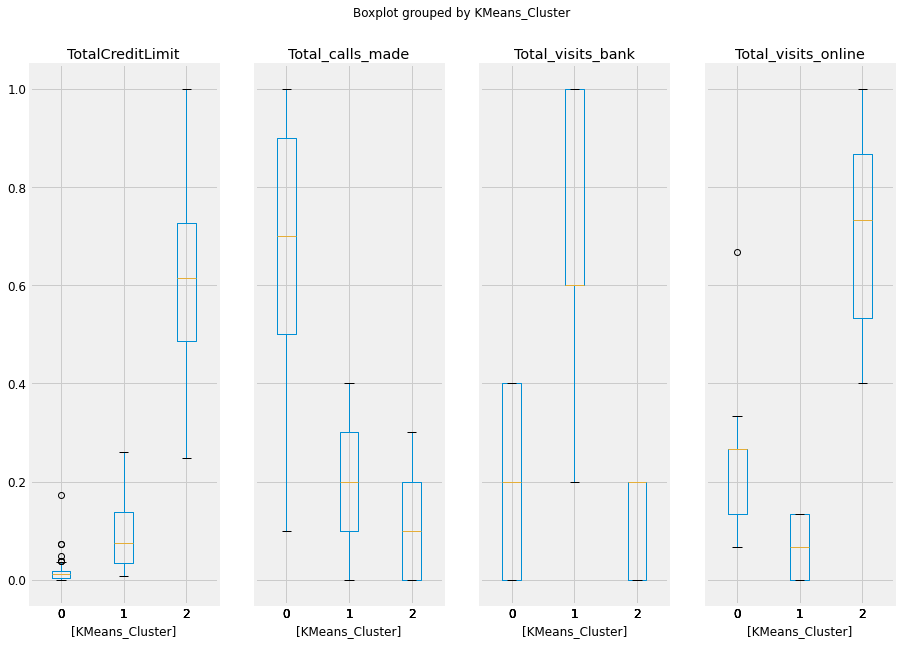

In [302]:
df.boxplot(by='KMeans_Cluster', layout = (1,4),figsize=(15,10));

**Cluster Analysis**
- Cluster 0: Customers with lower Total credit limit (fewer credit cards),more calls to bank, medium bank visits, medium online visits
- Cluster 1: Customers with medium credit limit (medium number of credit cards), few calls made, more bank visits and very less online visits
- Cluster 2: It includes cutomers with higher Total credit limit (higher number of credit cards), fewer calls made to bank, very less bank visits and highest online visits

###  Dimentionality Reduction using PCA

In [366]:
pca = PCA(n_components=0.95)
df_red = pca.fit_transform(df)

In [304]:
pca.explained_variance_ratio_

array([0.72468703, 0.200163  , 0.04346872])

In [305]:
pca_df = pd.DataFrame(df_red)

**Observation**

By reducing the original dimensions to 3, we are able to get 95% of variance explained

In [306]:
pca_df

,0,1,2
0,0.2974,0.1637,0.3998
1,-0.9518,0.5355,-0.2254
2,-0.7161,0.1014,0.2094
3,-0.7360,0.0083,0.2593
4,1.0742,0.9956,-0.1685
...,...,...,...
655,1.2611,0.7825,-0.0016
656,1.1808,0.8896,-0.2101
657,1.2367,0.7929,-0.0770
658,1.3300,1.0493,-0.1417


In [103]:
pca_df = pd.DataFrame(df_red)

**Using KMeans on PCA implemented Dataset**


In [367]:
cluster_range = range(1,10)
cluster_errors = []
for num_clusters in cluster_range:
    clusters = KMeans( num_clusters, n_init = 500,max_iter=1000,random_state=random_state,init="k-means++",)
    clusters.fit(pca_df)
    labels = clusters.labels_
    centroids = clusters.cluster_centers_
    cluster_errors.append(clusters.inertia_)

clusters_df = pd.DataFrame({"num_clusters": cluster_range, "cluster_errors": cluster_errors})
clusters_df.sort_values('cluster_errors', ascending=True,inplace=True)
clusters_df[0:15]

,num_clusters,cluster_errors
8,9,10.6260
7,8,12.0560
6,7,14.5135
5,6,17.0417
4,5,19.6540
3,4,25.4420
2,3,38.6665
1,2,173.3802
0,1,614.9576


Text(0, 0.5, 'Inertia or WCSS')

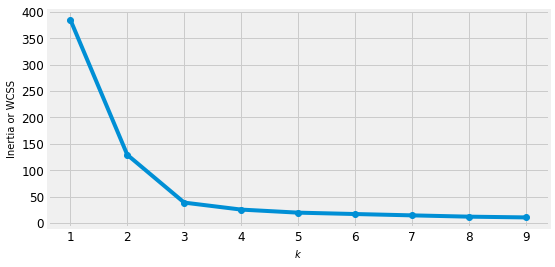

In [308]:
plt.figure(figsize=(8,4))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" );
plt.xlabel("$k$", fontsize=10)
plt.ylabel("Inertia or WCSS", fontsize=10)

**Obesrvation:**
- At K=3 we have inertia of cluster errors of 25.44


In [309]:
silhouette_score_list = []
kmeans_kwargs = {
    "init": "k-means++",
   "n_init": 20,
   "max_iter": 300,
   "random_state": random_state,}

for k in range(2, 15):
   kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans.fit_predict(df)
   score = silhouette_score(df, kmeans.labels_)
   silhouette_score_list.append(score)

In [310]:
silhouette_score_list_ = []
kmeans_kwargs = {
    "init": "k-means++",
   "n_init": 100,
   "max_iter": 3000,
   "random_state": random_state,}

for k in range(2, 10):
   kmeans_= KMeans(n_clusters=k, **kmeans_kwargs)
   kmeans_.fit(pca_df)
   score_= silhouette_score(pca_df, kmeans_.labels_)
   silhouette_score_list_.append(score_)

In [152]:
silhouette_score_list_

[0.6741880305954735,
 0.7596940062000274,
 0.5929731202331114,
 0.46853536587620087,
 0.43438266747107745,
 0.4313314661847743,
 0.4362763154946725,
 0.4331552060749132]

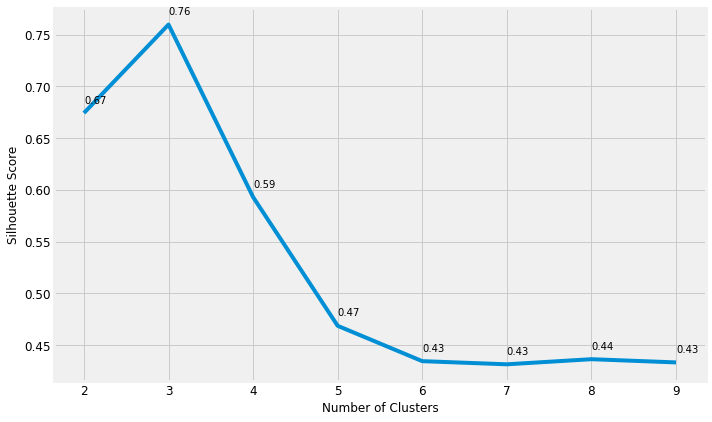

In [311]:
plt.figure(figsize=(10,6))
plt.plot(range(2, 10), silhouette_score_list_)
plt.xticks(range(2, 10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
# zip joins x and y coordinates in pairs
for x,y in zip(range(2, 10), silhouette_score_list_):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center
plt.tight_layout()

In [393]:
kmeans = KMeans(n_clusters=3, n_init = 500,max_iter=1000, random_state=random_state)
kmeans.fit(pca_df)
ypred = kmeans.labels_
pca_df['KMeans_Cluster'] = ypred

In [394]:
model_name.append('PCA_KMeans_')
score_name.append("silhouettescore")
score_value.append(round(silhouette_score(pca_df, kmeans.labels_),roundoff))
silhouette_score(pca_df, kmeans.labels_)

0.8115857372842838

In [380]:
model_name

['KMeans_', 'PCA_KMeans_']

In [382]:
score_value

[0.8116]

## Hierarchical Clustering
### Agglomerative Clustering


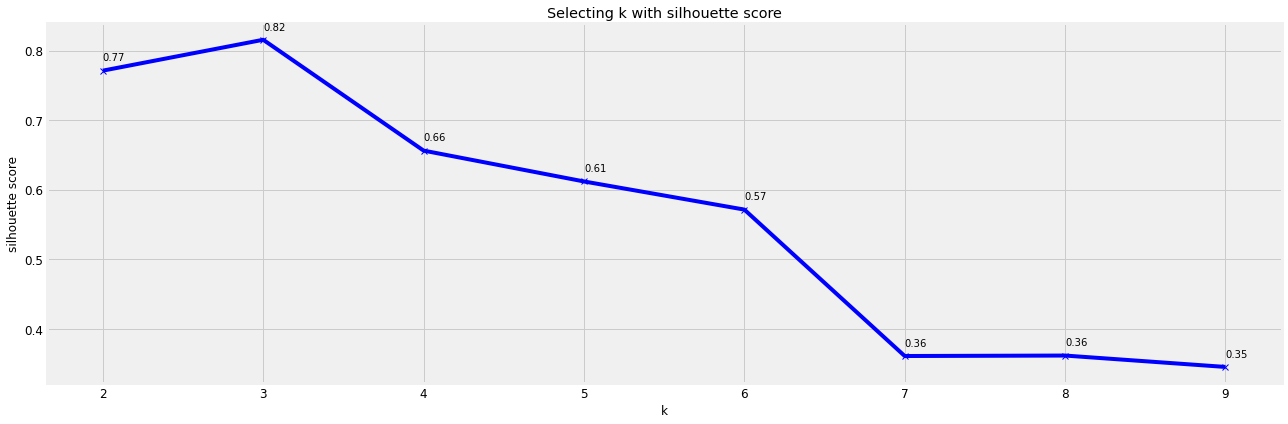

In [319]:
meanDistortions=[]
#Using Average linkage
for k in range(2, 10):
    model=AgglomerativeClustering(n_clusters=k, affinity='euclidean',  linkage='average')
    model.fit(df)
    prediction=model.labels_
    meanDistortions.append(silhouette_score(df, prediction))

fig = plt.figure(figsize=(18, 6))
plt.plot(range(2, 10), meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Selecting k with silhouette score');
# zip joins x and y coordinates in pairs
for x,y in zip(range(2, 15), meanDistortions):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='left') # horizontal alignment can be left, right or center
plt.tight_layout()

In [391]:
Aggmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='average')
Aggmodel.fit(df)
prediction = Aggmodel.labels_

In [392]:
model_name.append('AgglomerativeClustering_')
score_name.append("silhouettescore")
score_value.append(round(silhouette_score(df, prediction),roundoff))
silhouette_score(df, prediction)

0.7855134187912282

In [323]:
df_['agg_cluster'] = Aggmodel.labels_
df['agg_cluster'] = Aggmodel.labels_

In [324]:
df_.groupby('agg_cluster').mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMeans_Cluster
agg_cluster,,,,,,,,
0,118.2851,55032.4298,12416.6667,2.4693,0.9430,3.5263,6.8202,0.0000
1,611.2800,56708.7600,141040.0000,8.7400,0.6000,10.9000,1.0800,2.0000
2,420.4110,55001.3639,33863.8743,5.5131,3.5105,0.9712,1.9791,1.0000


**Observation**

- Cluster 0: Customers with low credit limit, fewer credit cards, medium bank visits, medium online visits and highest calls to bank
- Cluster 1: It includes cutomers with highest Avg credit limit, highest number of credit cards, very less bank visits, highest online visits and fewer calls made to bank
- Cluster 2: Customers with medium credit limit ,medium number of credit cards (~5,6), Highest average bank visits and very less online visits and medium calls to bank

In [193]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit,agg_cluster
0,0.2000,0.0667,0.0000,0.0977,2
1,0.0000,0.6667,0.9000,0.0727,0
2,0.2000,0.2000,0.4000,0.1729,0
3,0.2000,0.0667,0.4000,0.0727,0
4,0.0000,0.8000,0.3000,0.2982,1


In [326]:
df.drop("KMeans_Cluster", axis=1, inplace=True)

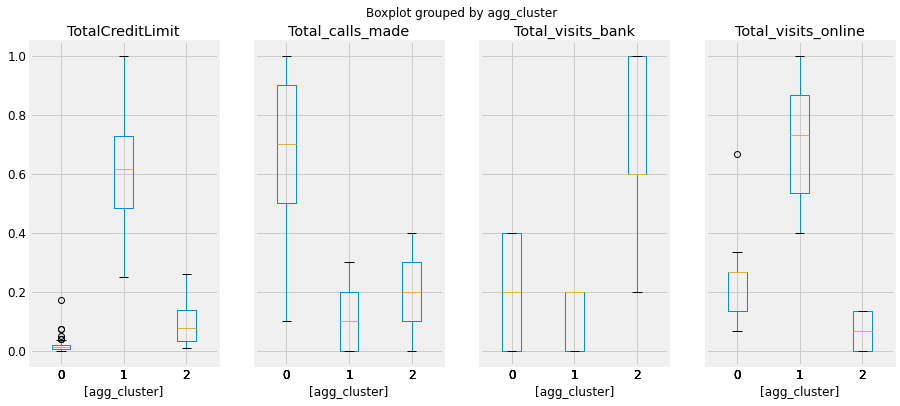

In [327]:
df.boxplot(by='agg_cluster', layout = (1,4),figsize=(15,6));

**Observation on Clusters created by Agg CLustering**

**Cluster Analysis:**

- Cluster 0: Customers with lower Total credit limit (fewer credit cards),more calls to bank, medium bank visits, medium online visits

- Cluster 1: It includes cutomers with higher Total credit limit (higher number of credit cards), fewer calls made to bank, less bank visits and highest online visits

- Cluster 2: Customers with medium credit limit (medium number of credit cards), few calls made, more bank visits and very less online visits

**Observation on Clusters created by Agg Clustering-Complete**

In [414]:
Aggmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
Aggmodel.fit(df)
prediction = Aggmodel.labels_

In [415]:
model_name.append('Agg_linkage_complete_')
score_name.append("silhouettescore")
score_value.append(round(silhouette_score(df, prediction),roundoff))
silhouette_score(df, prediction)

0.7855134187912282

In [330]:
df_['Agg_linkage_complete_'] = Aggmodel.labels_
df['Agg_linkage_complete_'] = Aggmodel.labels_

In [331]:
df_.groupby('Agg_linkage_complete_').mean()


,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMeans_Cluster,agg_cluster
Agg_linkage_complete_,,,,,,,,,
0,118.2851,55032.4298,12416.6667,2.4693,0.9430,3.5263,6.8202,0.0000,0.0000
1,420.4110,55001.3639,33863.8743,5.5131,3.5105,0.9712,1.9791,1.0000,2.0000
2,611.2800,56708.7600,141040.0000,8.7400,0.6000,10.9000,1.0800,2.0000,1.0000


In [333]:
df.drop("agg_cluster",axis=1, inplace=True)

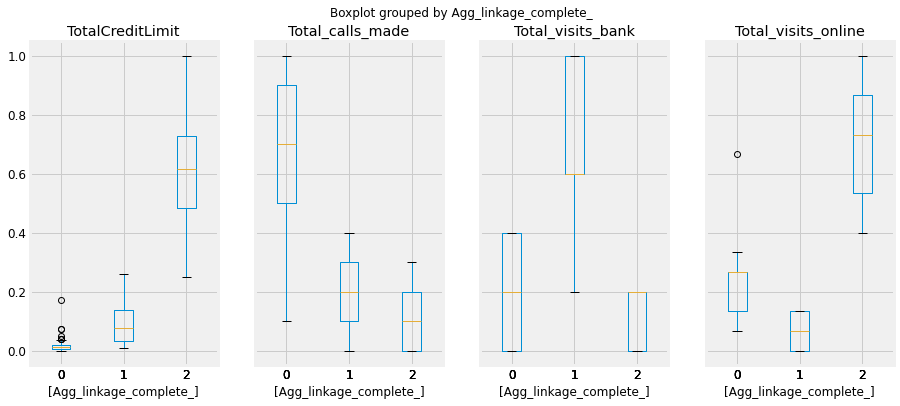

In [334]:
df.boxplot(by='Agg_linkage_complete_', layout=(1,4), figsize=(15,6));

**Cluster Analysis:**

- Cluster 0: Customers with lower Total credit limit (fewer credit cards),more calls to bank, medium bank visits, medium online visits
- Cluster 1: It includes cutomers with higher Total credit limit (higher number of credit cards), fewer calls made to bank, less bank visits and highest online visits
- Cluster 2: Customers with medium credit limit (medium number of credit cards), few calls made, more bank visits and very less online visits

**Agglomerative Clustering using ward linkage**

In [416]:
Aggmodel = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='ward')
Aggmodel.fit(df)
prediction = Aggmodel.labels_

In [417]:
model_name.append('Agg_linkage_ward_')
score_name.append("silhouettescore")
score_value.append(round(silhouette_score(df, prediction),roundoff))
silhouette_score(df, prediction)

0.7855134187912282

In [337]:
df_['Agg_linkage_ward_'] = Aggmodel.labels_
df['Agg_linkage_ward_'] = Aggmodel.labels_

In [338]:
df_.groupby('Agg_linkage_ward_').mean()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMeans_Cluster,agg_cluster,Agg_linkage_complete_
Agg_linkage_ward_,,,,,,,,,,
0,420.4110,55001.3639,33863.8743,5.5131,3.5105,0.9712,1.9791,1.0000,2.0000,1.0000
1,118.2851,55032.4298,12416.6667,2.4693,0.9430,3.5263,6.8202,0.0000,0.0000,0.0000
2,611.2800,56708.7600,141040.0000,8.7400,0.6000,10.9000,1.0800,2.0000,1.0000,2.0000


In [340]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit,Agg_linkage_complete_,Agg_linkage_ward_
0,0.2000,0.0667,0.0000,0.0977,1,0
1,0.0000,0.6667,0.9000,0.0727,0,1
2,0.2000,0.2000,0.4000,0.1729,0,1
3,0.2000,0.0667,0.4000,0.0727,0,1
4,0.0000,0.8000,0.3000,0.2982,2,2


In [341]:
df.drop("Agg_linkage_complete_", axis=1, inplace=True)

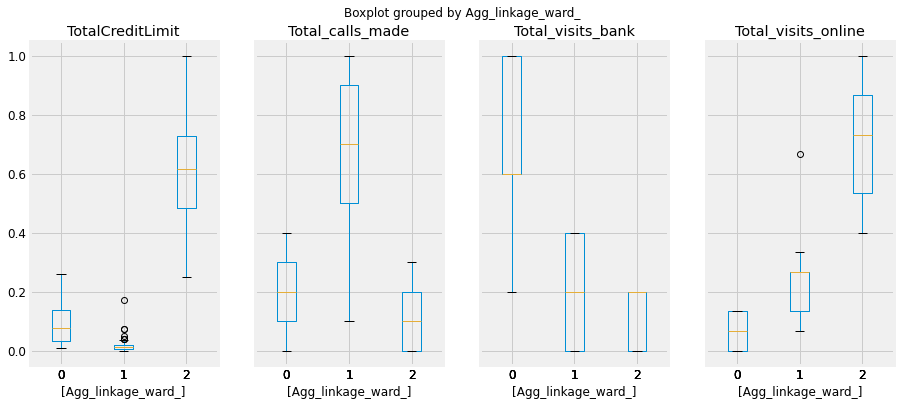

In [342]:
df.boxplot(by='Agg_linkage_ward_', layout=(1,4), figsize=(15,6));

**Cluster Analysis:**
- Cluster 0: Customers with medium credit limit (medium number of credit cards), few calls made, more bank visits and very less online visits
- Cluster 1: Customers with lower Total credit limit (fewer credit cards),more calls to bank, medium bank visits, medium online visits
- Cluster 2: It includes cutomers with higher Total credit limit (higher number of credit cards), fewer calls made to bank, less bank visits and highest online visits

### Different Linkages using Scipy Cluster



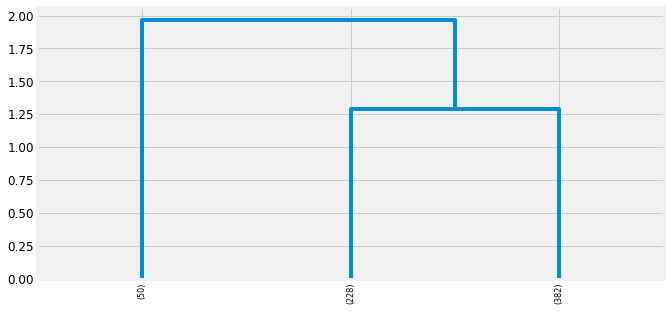

In [343]:
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist 

ZAvg = linkage(df, metric='euclidean', method='average',optimal_ordering=True)
# Compute the cophenetic correlation
c, coph_dists = cophenet(ZAvg , pdist(df))
plt.figure(figsize=(10, 5))

dendrogram(ZAvg, p=3, truncate_mode='lastp', leaf_rotation=90.,color_threshold = 0.8,  leaf_font_size=8.)
plt.show()

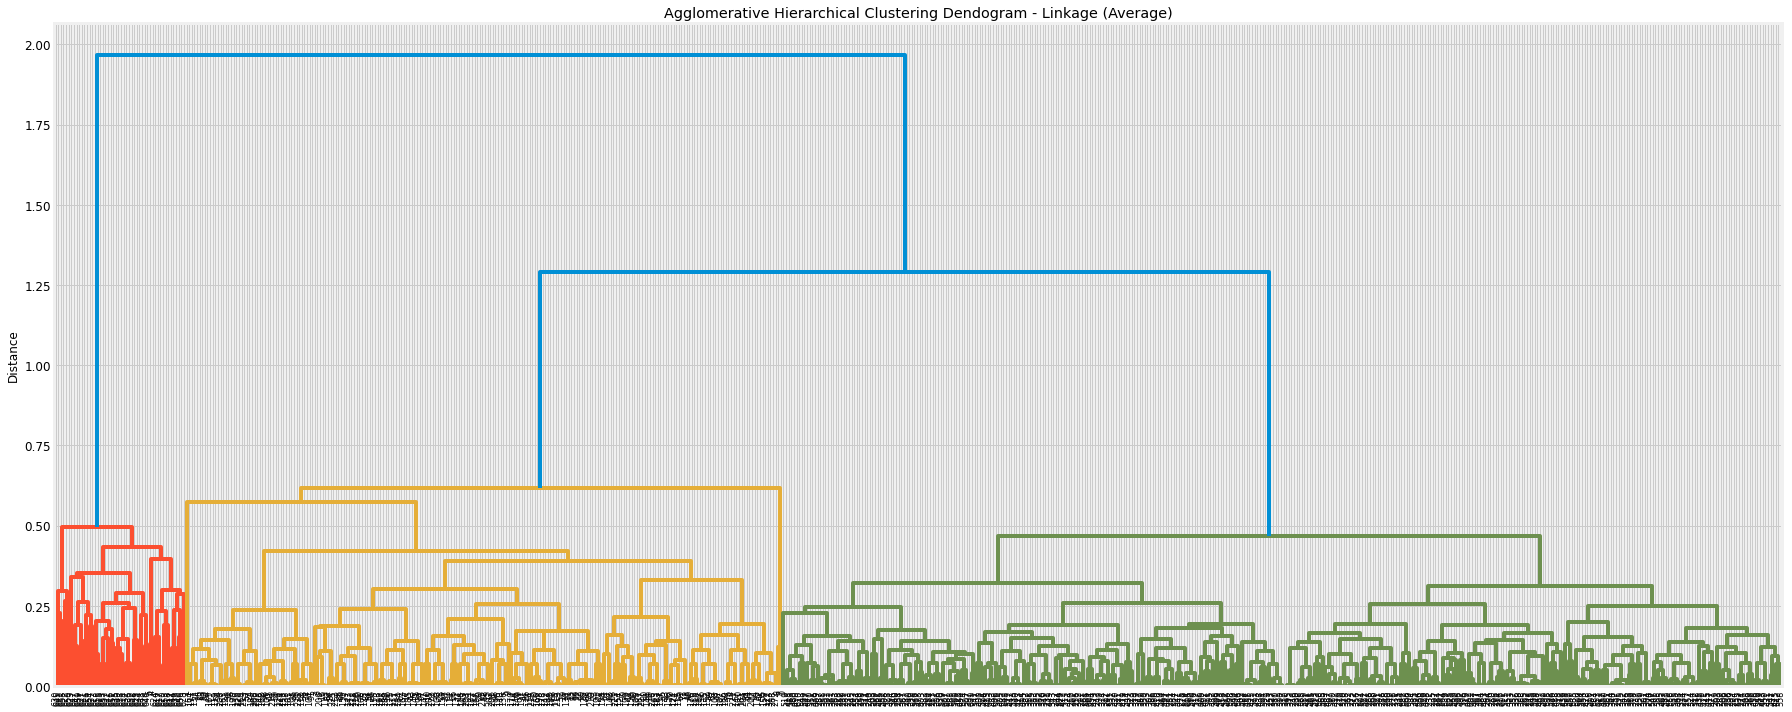

In [344]:
plt.figure(figsize=(25, 10))
plt.title('Agglomerative Hierarchical Clustering Dendogram - Linkage (Average)')
plt.ylabel('Distance')
dendrogram(ZAvg, leaf_rotation=90.,color_threshold = 0.7, leaf_font_size=8. )
plt.tight_layout()

In [231]:
c

0.9487491255121405

**Linkage - Complete**


In [399]:
Zcomp = linkage(df, metric='euclidean', method='complete')
c, coph_dists = cophenet(Zcomp , pdist(df))

c

0.9803430054284479

In [400]:
model_name.append('Linkage_Complete')
score_name.append("cophenetic correlation")
score_value.append(round(c,roundoff))

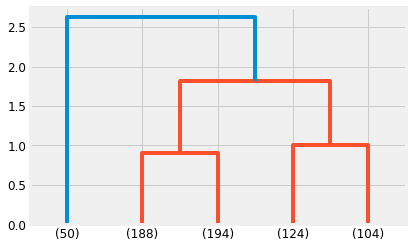

In [347]:
dendrogram(
    Zcomp,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=5,  # show only the last p merged clusters
)
plt.show()

In [348]:
linkage_Complete = fcluster(Zcomp, 1.4, criterion='distance')

In [243]:
model_name.append('linkage_Complete')
score_name.append("silhouettescore")
score_value.append(round(silhouette_score(df, linkage_Complete),roundoff))
silhouette_score(df, linkage_Complete)

0.7218405023094998

In [349]:
df_['linkage_Complete'] = linkage_Complete
df['linkage_Complete'] = linkage_Complete

In [350]:
df_.groupby('linkage_Complete').count()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,KMeans_Cluster,agg_cluster,Agg_linkage_complete_,Agg_linkage_ward_
linkage_Complete,,,,,,,,,,,
1,50,50,50,50,50,50,50,50,50,50,50
2,382,382,382,382,382,382,382,382,382,382,382
3,228,228,228,228,228,228,228,228,228,228,228


In [253]:
df.drop("Agg_linkage_ward_", axis=1, inplace=True)

In [254]:
df.head()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit,linkage_Complete
0,0.2000,0.0667,0.0000,0.0977,2
1,0.0000,0.6667,0.9000,0.0727,3
2,0.2000,0.2000,0.4000,0.1729,3
3,0.2000,0.0667,0.4000,0.0727,3
4,0.0000,0.8000,0.3000,0.2982,1


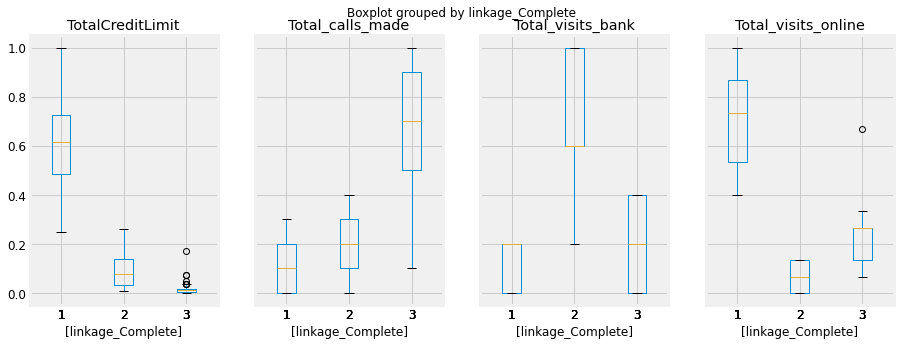

In [255]:
df.boxplot(by='linkage_Complete',layout = (1,4),figsize=(15,5));

**Observation**

***Cluster Analysis:***

- Cluster 1: It includes cutomers with higher Total credit limit (higher number of credit cards), fewer calls made to bank, very less bank visits and highest online visits
- Cluster 2: Customers with medium credit limit (medium number of credit cards), few calls made, more bank visits and very less online visits
- Cluster 3: Customers with lower Total credit limit (fewer credit cards),more calls to bank, medium bank visits, medium online visits

In [261]:
df = df_final.copy()

In [262]:
df.copy()

,Total_visits_bank,Total_visits_online,Total_calls_made,TotalCreditLimit
0,0.2000,0.0667,0.0000,0.0977
1,0.0000,0.6667,0.9000,0.0727
2,0.2000,0.2000,0.4000,0.1729
3,0.2000,0.0667,0.4000,0.0727
4,0.0000,0.8000,0.3000,0.2982
...,...,...,...,...
655,0.2000,0.6667,0.0000,0.4937
656,0.2000,0.8667,0.2000,0.4185
657,0.2000,0.6000,0.1000,0.5789
658,0.2000,1.0000,0.0000,0.8596


In [402]:
score_value

[0.7855, 0.7855, 0.8116, 0.7855, 0.7855, 0.9803]

In [401]:
model_name

['KMeans_',
 'AgglomerativeClustering_',
 'PCA_KMeans_',
 'Agg_linkage_complete_',
 'Agg_linkage_ward_',
 'Linkage_Complete']

In [413]:
Allmodels = pd.DataFrame({"Model Name":model_name,"Score Type":score_name,"Score":score_value})
Allmodels.sort_values(['Score',],ascending=False)

,Model Name,Score Type,Score
5,Linkage_Complete,cophenetic correlation,0.9803
2,PCA_KMeans_,silhouettescore,0.8116
0,KMeans_,silhouette score,0.7855
1,AgglomerativeClustering_,silhouettescore,0.7855
3,Agg_linkage_complete_,silhouettescore,0.7855
4,Agg_linkage_ward_,silhouettescore,0.7855


**Observation**

- Linkage_Complete has highest CC of ~0.98 compared to other scipy linkage models
- With respect to Silhouette scores -> KMeans on PCA has the highest Sil. Score of ~0.81 out performing other models. Followed by
- KMeans_ without PCA with Sil. Score of ~0.78. Agg Clustering with euclidean and Avg, Agg Clustering with euclidean and complete, and  gg Clustering with euclidean and ward have same scores of 0.7855


Three distinct categories of customers based on credit limit and their mode of communication with bank
These segments mainly differ based on credit limits as below.

-  Customers who have high credit limit seems to be high spenders with more number of credit cards and they prefer to bank online rather visiting the bank or calling bank
- Customers who have low credit limit have less number of credit cards and have more calls made to the bank
- Customers with medium credit limit have more credit cards when compared to low credit customers and have less calls made to bank as compared to low credit customers but have more visits to bank overall

**Recommendations**

It is recommended that products are marketed to specific segment of customers through their preferred channel. There are three categories/segments of customers with each segment having a preference for communication channel with bank. Therefore, services can be provided based on their average credit limit and the most observed communication pattern.

- Customers with high credit limit tend to vist online: can be targeted for online campaigns, coupons and accordingly products and services can be offered to them
- Customers with comparatively low credit limit make visits to bank more often: they can either be can be catered with in-bank offers and services and flyers.
- Customers with low credit limits have less frequency on online platform: they can be marketed with benefits of online banking and/or make customer call center reps aware of promotions and offers so that they can target this segment of customers.